In [1]:
# unet
import torch
import torch.nn as nn


In [2]:
import torch
from torch.utils.data import Dataset,DataLoader 
import numpy as np
import matplotlib.pyplot as plt
import os


In [3]:
def creatDownSampling(in_channels,out_channels,f_size=4):
    ds = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=f_size,stride=2,padding=1),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(),
    )
    return ds 

def creatUpSampling(in_channels,out_channels,f_size=3,dropout_rate=0):
    us = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels,out_channels,kernel_size=f_size,stride=1,padding=1,),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(),
    )
    if dropout_rate:
        us = nn.Sequential(
            us,
            nn.Dropout(dropout_rate)
        )
    return us


In [9]:
from torch.optim import Adam

class UNET(nn.Module):
    def __init__(self,filters=32):
        super().__init__()
        self.filters = filters
        self.ds1 = creatDownSampling(3,self.filters,4)
        #[-1, 32, 64, 64]
        self.ds2 = creatDownSampling(self.filters,2*self.filters,4)
        #[-1, 64, 31, 31]
        self.ds3 = creatDownSampling(2*self.filters,4*self.filters)
        #[-1, 128, 16, 16] 
        self.ds4 = creatDownSampling(4*self.filters,8*self.filters)
        #[-1, 256, 8, 8]
        self.us1 = creatUpSampling(8*self.filters,4*self.filters)
        #upsample #[-1, 256, 16, 16]
        #conv2d [-1, 128, 16, 16]
        #concat [-1, 256, 32, 32]
        self.us2 = creatUpSampling(8*self.filters,2*self.filters)
        self.us3 = creatUpSampling(4*self.filters,self.filters)
        self.output = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(2*self.filters,3,kernel_size=3,stride=1,padding=1),
            nn.Tanh(),
        )
        self.loss_function = nn.L1Loss()
        self.optimizer = Adam(self.parameters(),lr=0.0005)
    def forward(self,x): #[2,3,256,256]
        d1 = self.ds1(x) #[2, 32, 128, 128]
        d2 = self.ds2(d1)#[2, 64, 64, 64] 
        d3 = self.ds3(d2) #[2, 128, 32, 32]
        d4 = self.ds4(d3)#[2, 256, 16, 16]
        u1 = self.us1(d4) #[2, 128, 32, 32]
        u1 = torch.concatenate([u1,d3],dim=1) #[2, 256, 32, 32]
        u2 = self.us2(u1) #[2, 64, 64, 64]
        u2 = torch.concatenate([u2,d2],dim=1) #[2, 128, 64, 64]
        u3 = self.us3(u2) #[2, 32, 128, 128]
        u3 = torch.concatenate([u3,d1],dim=1) #[2, 64, 128, 128]
        output = self.output(u3) #[2, 3, 256, 256]
        return output
        

    def train(self,x_batch,label_imgs):
        self.optimizer.zero_grad()
        fake_imgs = self.forward(x_batch)

        loss = self.loss_function(fake_imgs,label_imgs)
        loss.backward()
        self.optimizer.step()
        return loss

In [ ]:
dummy = torch.ones([2,3,256,256])
unet = UNET()
unet(dummy)

In [10]:
# [-1,3,128,128] -> [-1,32, 64,64] -> [-1,64,32,32]->[-1,128,16,16]->[-1,256,16,16] ->[-1,1,16,16]

class D(nn.Module):
    def __init__(self,filters=32):
        super().__init__()
        self.filters = filters
        self.d1 = self.conv4(3,filters,norm=False) #[2, 32, 128, 128]
        self.d2 = self.conv4(filters,2*filters) #[2, 64, 64, 64]
        self.d3 = self.conv4(2*filters,4*filters) #[2, 128, 32, 32]
        self.d4 = self.conv4(4*filters,8*filters) #[2, 256, 16, 16]
        self.d5 = nn.Sequential(
                nn.Conv2d(8*filters,1,kernel_size=3,stride=1,padding=1),
            ) #[2, 1, 32, 32]
        # 손실 함수 생성
        self.loss_function = nn.MSELoss()
        # 옵티마이저 생성
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0005)
    def forward(self,x):
        y = self.d1(x)
        y = self.d2(y)
        y = self.d3(y)
        y = self.d4(y)
        y = self.d5(y)
        return y
    def conv4(self,in_channels,out_channels,f_size=4,stride=2,norm=True):
        if norm:
            conv4 = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=f_size,stride=stride,padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(0.2),
            )
        else:
            conv4 = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=f_size,stride=stride,padding=1),
                nn.LeakyReLU(0.2),
            )
        return conv4

    def train(self,x_batch,label):
        self.optimizer.zero_grad()
        y_pred = self.forward(x_batch)
        
        loss = self.loss_function(y_pred,label)
        loss.backward()
        self.optimizer.step()
        return loss


In [53]:
dummy = torch.ones([2,3,256,256])
d = D()
d(dummy).shape

torch.Size([2, 1, 16, 16])

In [11]:
from glob import glob
import cv2 as cv

class apple2orangeDataLoader():
    
    def __init__(self, dataset_name='apple2orange', img_res=(256, 256)):
        self.dataset_name = dataset_name
        self.img_res = img_res
        pass
    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        path_A = glob('./data/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./data/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = cv.resize(img_A, self.img_res)
                img_B = cv.resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield torch.FloatTensor(imgs_A.transpose(0,3,1,2)), torch.FloatTensor(imgs_B.transpose(0,3,1,2))  
            
    def imread(self, path):
        img = cv.imread(path)
        img =cv.cvtColor(img,cv.COLOR_RGB2BGR)
        return img
    

In [12]:
d_A = D()
d_B = D()
u_A = UNET()
u_B = UNET()
dummy = torch.ones([2,3,256,256])

In [32]:
import matplotlib.pyplot as plt

dataloader = apple2orangeDataLoader()
batch_size = 4
patch = int(256/2**4)
disc_patch = (1,patch,patch) #[1,16,16]

real_label = torch.ones((batch_size,)+disc_patch)
fake_label = torch.zeros((batch_size,)+disc_patch)

dA_loss_hist = []
dB_loss_hist = []
gA_loss_hist =[]
gB_loss_hist =[]

epoch=1
for iter,(imgs_A,imgs_B) in enumerate(dataloader.load_batch(batch_size=batch_size)):

    fake_B = u_B(imgs_A).detach()
    fake_A = u_A(imgs_B).detach()

    d_B_loss = d_B.train(imgs_B,real_label)
    d_B_fake_loss = d_B.train(fake_B,fake_label)
    d_A_loss =d_A.train(imgs_A,real_label)
    d_A_fake_loss = d_A.train(fake_A,fake_label)

    recons_A = u_A(fake_B)
    recons_B = u_B(fake_A)
    g_A_rec_loss = u_A.train(recons_A,imgs_A)
    g_B_rec_loss = u_B.train(recons_B,imgs_B)
    
    idt_A = u_A(imgs_A)
    idt_B = u_B(imgs_B)
    
    g_A_idt_loss = u_A.train(idt_A,imgs_A)
    g_B_idt_loss = u_B.train(idt_B,imgs_B)

    total_d_A_loss =(d_A_loss.item()+d_A_fake_loss.item())/2
    total_d_B_loss =(d_B_loss.item()+d_B_fake_loss.item())/2
    dA_loss_hist.append(total_d_A_loss)
    dB_loss_hist.append(total_d_B_loss)

    total_g_A_loss =(g_A_rec_loss.item()+g_A_idt_loss.item())/2
    total_g_B_loss =(g_B_rec_loss.item()+g_B_idt_loss.item())/2
    gA_loss_hist.append(total_g_A_loss)
    gB_loss_hist.append(total_g_B_loss)

    print(f"Epoch {epoch}: d_A_loss = {total_d_A_loss:.7f} | d_B_loss = {total_d_B_loss:.7f} | total_g_A_loss={total_g_A_loss:.7f} | total_g_B_loss={total_g_B_loss:.7f}")
    if iter==1:
        break


Epoch 1: d_A_loss = 0.3068540 | d_B_loss = 0.2966956 | total_g_A_loss=0.4291487 | total_g_B_loss=0.5233044
Epoch 1: d_A_loss = 0.3161766 | d_B_loss = 0.2780422 | total_g_A_loss=0.4784485 | total_g_B_loss=0.4577541


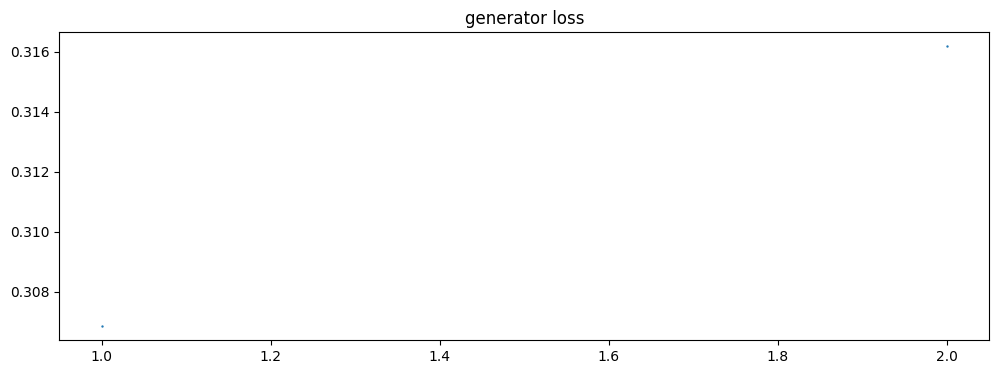

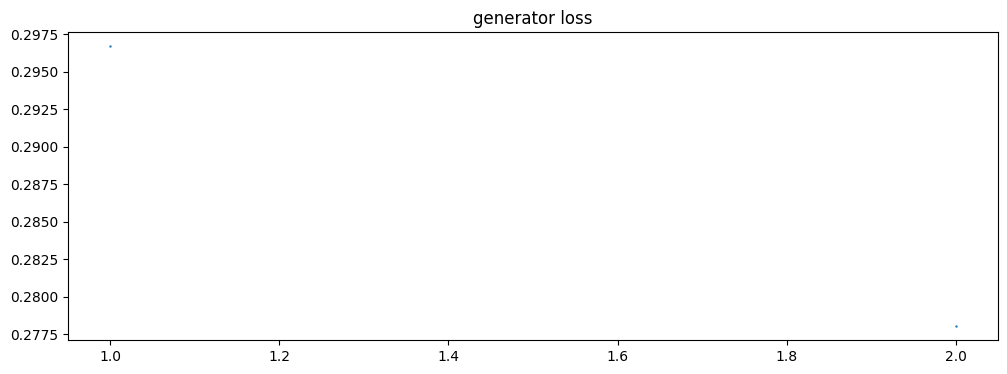

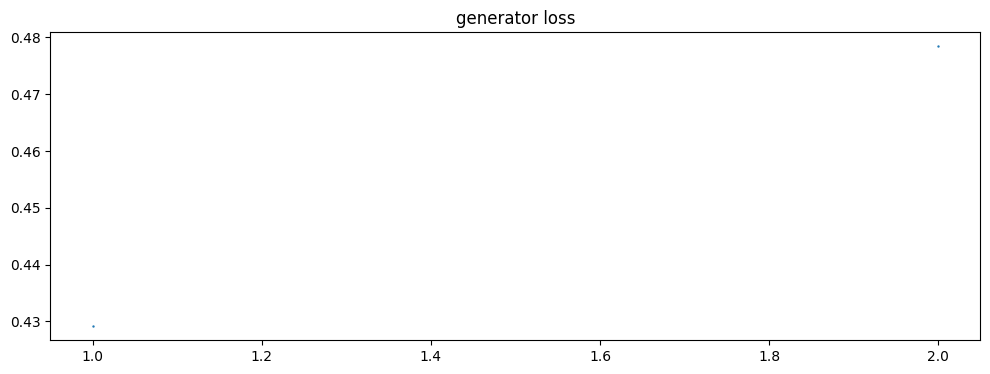

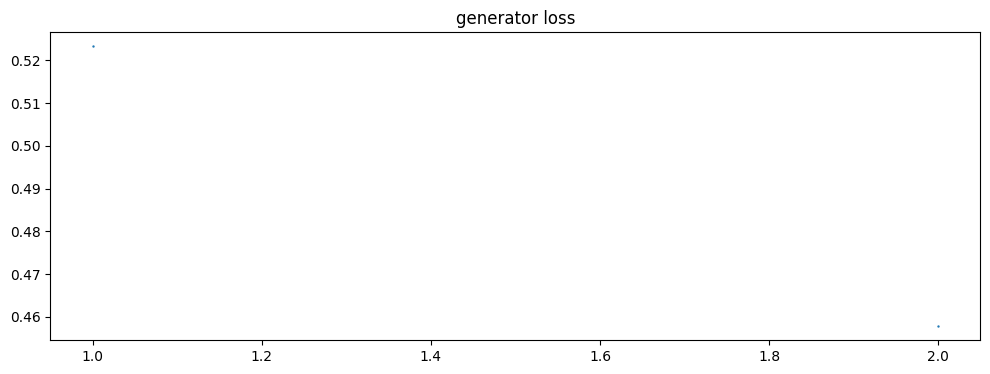

In [33]:
def visualize(loss_hist):
    plt.figure(figsize=(12,4))
    plt.scatter(np.arange(1,len(loss_hist)+1),loss_hist,s=0.5)
    plt.title('generator loss')
    plt.show()
visualize(dA_loss_hist)
visualize(dB_loss_hist)
visualize(gA_loss_hist)
visualize(gB_loss_hist)

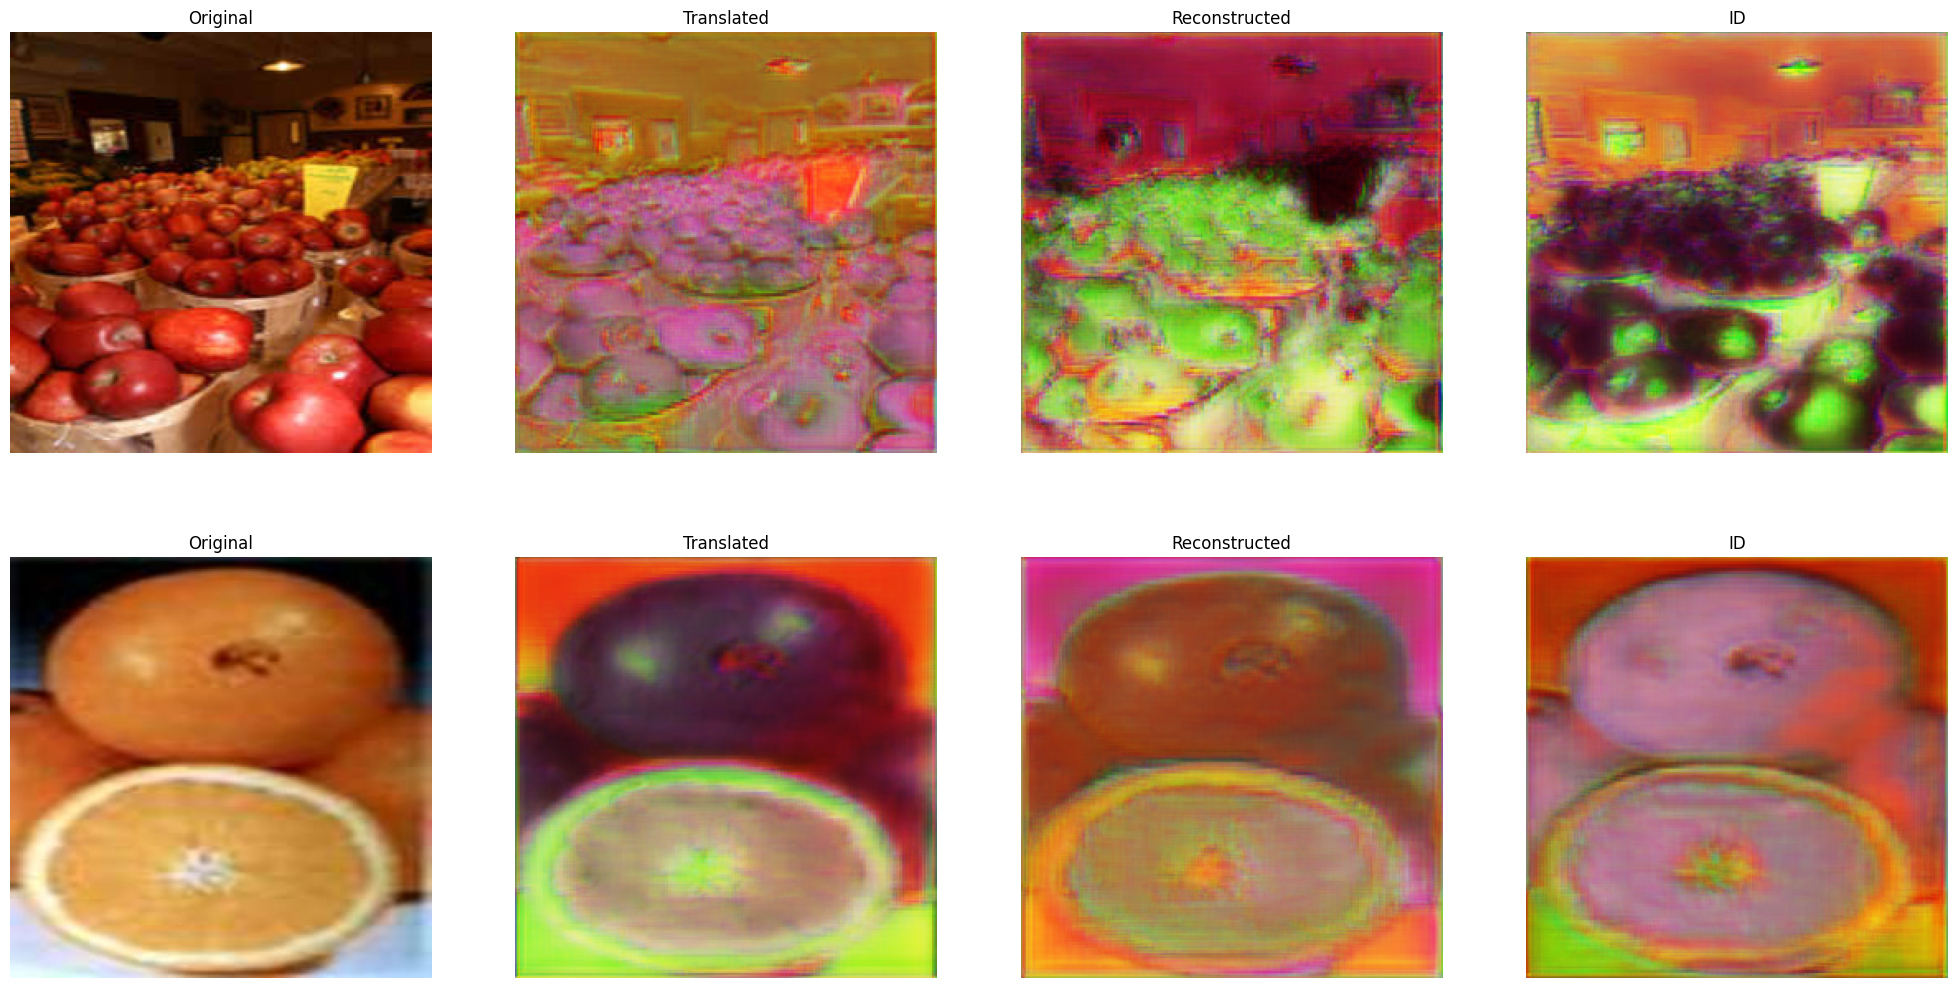

In [31]:
def sample_images(data_loader):
    
    r, c = 2, 4
    for iter,(imgs_A,imgs_B) in enumerate(dataloader.load_batch(batch_size=1)):

        fake_B = u_B(imgs_A).detach()
        fake_A = u_A(imgs_B).detach()

        recons_A = u_A(fake_B)
        recons_B = u_B(fake_A)
        
        idt_A = u_A(imgs_A)
        idt_B = u_B(imgs_B)
        gen_imgs = torch.concatenate([imgs_A, fake_B, recons_A, idt_A, imgs_B, fake_A, recons_B, idt_B]).detach().numpy().transpose((0,2,3,1))

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        gen_imgs = np.clip(gen_imgs, 0, 1)

        titles = ['Original', 'Translated', 'Reconstructed', 'ID']
        fig, axs = plt.subplots(r, c, figsize=(25,12.5))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        
        break


sample_images(dataloader)
